# Simulate and Plot

## Import and Setting the Verbosity Level

We first import the `andes` library and the `get_case` function that for loading test cases shipped with ANDES.

In [1]:
import andes

from andes.utils.paths import get_case

We can configure the verbosity level for logging (output messages) by passing a verbosity level (10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL) to the `stream_level` argument of `andes.main.config_logger()`. Verbose level 10 is useful for getting debug output.

The logging level can be altered (as of v1.4.3) by calling ``config_logger`` again with new ``stream_level`` and ``file_level``.

In [2]:
andes.config_logger(stream_level=20)

Note that the above ``andes.config_logger()`` is a shorthand to ``andes.main.config_logger()``.

If this step is omitted, the default `INFO` level (`stream_level=20`) will be used.

## Run Time-Domain Simulation

### Run power flow by default

`get_case` takes a relative path to `ANDES_ROOT/andes/cases` and returns the full path, where `ANDES_ROOT` is the root folder of ANDES.

`andes.run` is the entrypoint function for loading files and running routines. It runs power flow by default and returns a `System` object.

Note: if `default_config=True`, the default concif will be used. To use your own config, remove `default_config=True`.

See the tutorial for saving and editing ANDES config. 

In [3]:
ss = andes.run(get_case('smib/SMIB.xlsx'), default_config=True)

Working directory: "/home/sarute/Documents/andes/examples"
> Loaded generated Python code in "/home/sarute/.andes/pycode".
Parsing input file "/home/sarute/Documents/.venv/lib/python3.12/site-packages/andes/cases/smib/SMIB.xlsx"...
Input file parsed in 0.6373 seconds.
System internal structure set up in 0.0766 seconds.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0116 seconds.
0: |F(x)| = 0.8999999767
1: |F(x)| = 0.1527265608
2: |F(x)| = 0.001820592291
3: |F(x)| = 2.745872862e-07
Converged in 4 iterations in 0.0176 seconds.
Report saved to "SMIB_out.txt" in 0.0029 seconds.


-> Single process finished in 1.3431 seconds.


### Run time-domain simulation 
Run TDS by calling `TDS.run()` on the system. Note that the call must follow the power flow immediately.

The default simulation is for 20 seconds. To change if, change ``config.tf`` to the desired value.

In [4]:
ss.TDS.config.tf = 10  # simulate for 10 seconds

In [5]:
ss.TDS.run()

GENCLS (vf range) out of typical lower limit.

   idx    | values | limit
----------+--------+------
 GENCLS_2 | 1.000  | 1    


Initialization for dynamics completed in 0.0989 seconds.
Initialization was successful.


  0%|          | 0/100 [00:00<?, ?%/s]

<Fault Fault_1>: Applying fault on Bus (idx=3) at t=0.1 sec.
<Fault Fault_1>: Clearing fault on Bus (idx=3) at t=0.2 sec.


Simulation to t=10.00 sec completed in 1.5738 seconds.
Outputs to "SMIB_out.lst" and "SMIB_out.npz".
Outputs written in 0.0078 seconds.


True

To check if all operations completed successfully, check `ss.exit_code`. `exit_code == 0` means that all operations were successful. 

If not zero, `exit_code` indicates the number of errors caught. One will need to check output messages for errors.

In [6]:
ss.exit_code

0

## Export and Plot Results

If you are using ANDES interactively from Jupyter Notebook or IPython, at the end of a time-domain simulation. a plotter object `ss.TDS.plt` will automatically be created.

To check if that has been created successfully (in case the detection of an interactive environment fails), check the type of `ss.TDS.plt`.

In [11]:
%matplotlib inline
ss.TDS.plt

If `ss.TDS.plt` is None, it can be manually loaded with `ss.TDS.load_plotter()`. Otherwise, `load_plotter()` can be safely skipped.

In [8]:
ss.TDS.load_plotter()

### Exporting simulation data to csv

To export simulation results to a CSV file, one can use `ss.TDS.plt.export_csv()`, which takes an optional argument of the file name. 

If not provided, a default file name will be assigned.

In [12]:
ss.TDS.plt.export_csv()

CSV data saved to "/home/sarute/Documents/andes/examples/SMIB_out.csv".


'/home/sarute/Documents/andes/examples/SMIB_out.csv'

### Index-based Plotting

`plotter.plot()` is the entry point for plotting. It is the backend of the command-line `andes plot`. 


Before plotting, open the `kundur_full_out.lst` to find the indices (first column) for the variables to plot.

For example, if we want to plot all generator speed, which is the `omega` variable of `GENROU`. 
By inspect, we found the indices as `5, 6, 7, 8`. 

Pass them in a tuple or a list to `ss.TDS.plt.plot`.

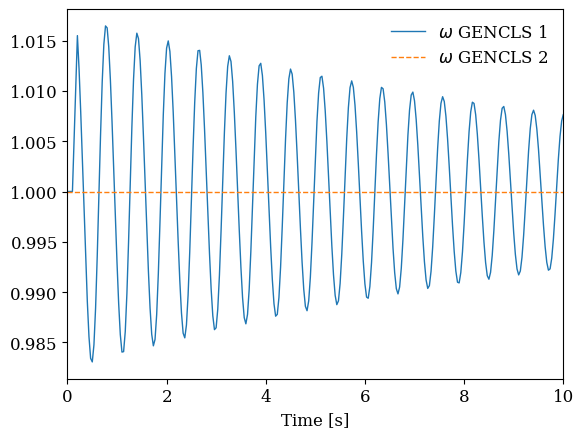

In [19]:
fig, ax = ss.TDS.plt.plot((3,4))

`plot()` returns a figure object and an axis object.

### Find index by variable name

`plotter.find()` is a method for finding indices based on variable name.

The first argument is the pattern to find. An optional argument `exclude` is the pattern to exclude. Regular expression is supported for both.

In [20]:
ss.TDS.plt.find('omega')

([3, 4], ['omega GENCLS 1', 'omega GENCLS 2'])

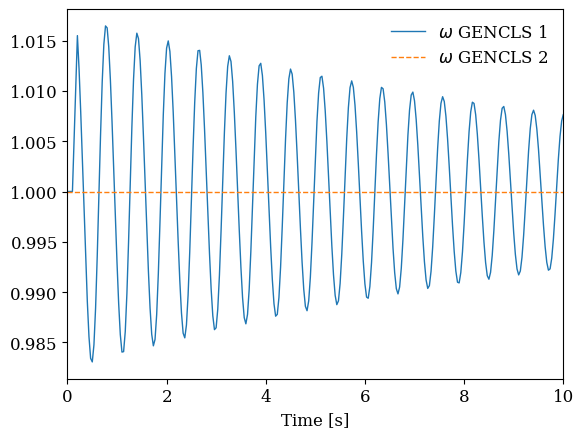

In [21]:
fig, ax = ss.TDS.plotter.plot(ss.TDS.plotter.find('omega')[0])

### Plotting by variable

Looking up indices from the `lst` file can be tedious. 

Instead, one can pass a a variable in a model to `ss.TDS.plt.plot`. For example, to plot `ss.GENROU.omega`, do

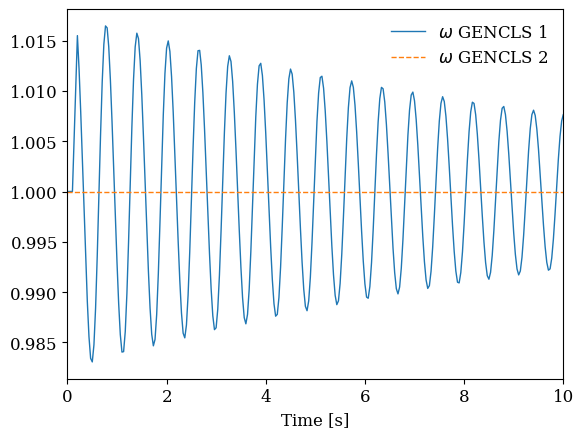

In [24]:
fig, ax = ss.TDS.plt.plot(ss.GENCLS.omega)

To plot a subset of the variables, pass the 0-indexed selection indices in a tuple through argument `a` of `ss.TDS.plt.plot`. For example, to plot the 0-th and the 3-th `GENROU.omega`, do

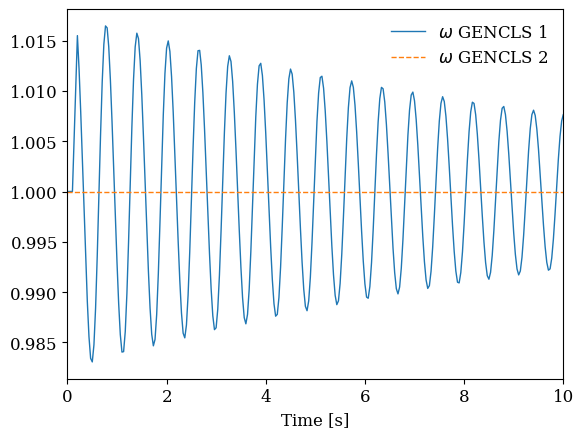

In [28]:
fig, ax = ss.TDS.plt.plot(ss.GENCLS.omega, a=(0, 1))

### Adding curves to an existing figure

Plotting curves into an existing figure allows easy comparison of results. It can be done by passing a figure and an axis object of `plot()`.

For example, to plot the speed of the second generator (a=1) on the figure above, do

<Figure size 432x288 with 0 Axes>

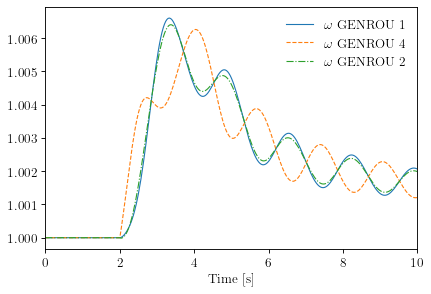

In [15]:
fig, ax = ss.TDS.plt.plot(ss.GENROU.omega, a=(1, ), fig=fig, ax=ax, linestyles=['-.'])
fig

### Y-axis label

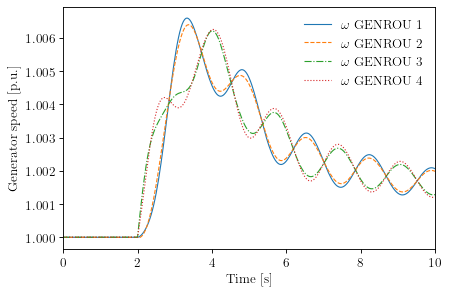

In [16]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8), ylabel='Generator speed [p.u.]')

### Legend names (yheader)

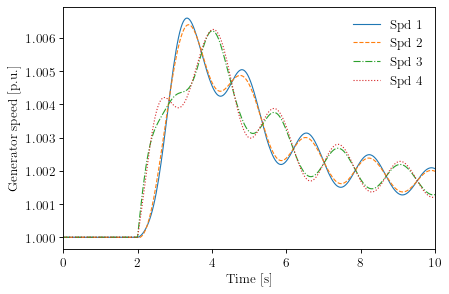

In [17]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8), ylabel='Generator speed [p.u.]', 
                              yheader=['Spd 1', 'Spd 2', 'Spd 3', 'Spd 4'])

Note that the number of elements passed to `yheader` should match the number of variables.
`yheader` only applies to new curves and cannot be used to modify existing legends.

### Scaling

A lambda functino can be passed to `ycalc` to scale the value. To scale the frequency from per unit to 60 Hz nominal values, use

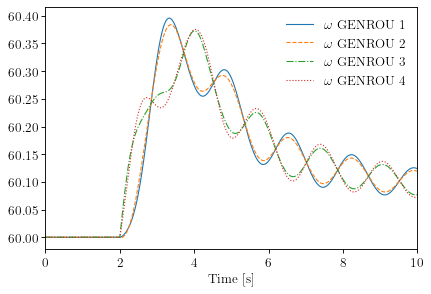

In [18]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8), ycalc=lambda x: 60 * x)

### Greyscale and Grid

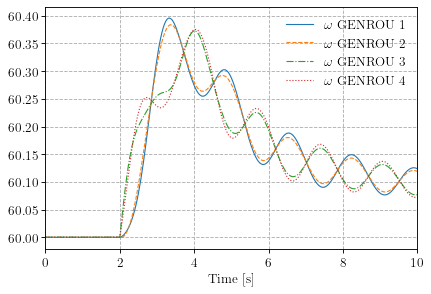

In [19]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8),
                              ycalc=lambda x: 60 * x,
                              greyscale=True,
                              grid=True)

### Save figure

Pass `savefig = True` to save the figure to a `png` file. 

Figure saved to "kundur_full_out_1.png".


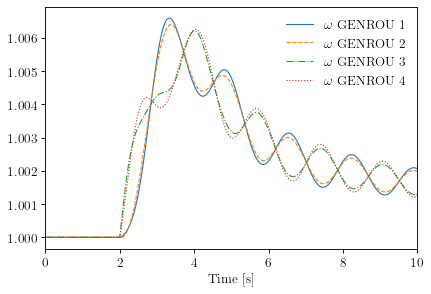

In [20]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8), savefig=True)

### Additional arguments

`plotter.plot` takes addition arguments. To check additional arguments, please use `help` or refer to the source code.

In [21]:
help(ss.TDS.plotter.plot)

Help on method plot in module andes.plot:

plot(yidx, xidx=(0,), *, a=None, ytimes=None, ycalc=None, left=None, right=None, ymin=None, ymax=None, xlabel=None, ylabel=None, xheader=None, yheader=None, legend=None, grid=False, greyscale=False, latex=True, dpi=80, line_width=1.0, font_size=12, savefig=None, save_format=None, show=True, title=None, linestyles=None, use_bqplot=False, hline1=None, hline2=None, vline1=None, vline2=None, hline=None, vline=None, fig=None, ax=None, backend=None, set_xlim=True, set_ylim=True, autoscale=False, legend_bbox=None, legend_loc=None, legend_ncol=1, figsize=None, color=None, **kwargs) method of andes.plot.TDSData instance
    Entry function for plotting.
    
    This function retrieves the x and y values based on the `xidx` and
    `yidx` inputs, applies scaling functions `ytimes` and `ycalc` sequentially,
    and delegates the plotting to the backend.
    
    Parameters
    ----------
    yidx : list or int
        The indices for the y-axis variables

## Cleanup

In [22]:
! andes misc -C

"/home/hacui/repos/andes/examples/kundur_full_out.npz" removed.
"/home/hacui/repos/andes/examples/kundur_full_out.txt" removed.
"/home/hacui/repos/andes/examples/kundur_full_out.lst" removed.
"/home/hacui/repos/andes/examples/kundur_full_out.csv" removed.


In [23]:
!rm kundur_full_out_1.png